# Bid-ask spread and other measures for HFT 

## Question 1

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('TAQ_CAT_QUOTE_0104_2010.csv',sep='\s+')

In [3]:
data.head()

,DATE,Hour,Minute,Second,BID,OFR,BIDSIZ,OFRSIZ
0,20100104,4,7,0,56.97,57.89,5,5
1,20100104,4,7,0,56.97,57.89,5,5
2,20100104,4,7,1,56.98,57.89,5,5
3,20100104,4,7,37,56.97,57.88,5,5
4,20100104,4,7,48,56.97,0.00,5,0


In [4]:
data_new = data['Hour'].copy()
data_new.head()

0    4
1    4
2    4
3    4
4    4
Name: Hour, dtype: int64

In [5]:
for i in range(len(data_new)):
    if data_new[i]<10:
        data_new.loc[i] = str('0'+str(data_new[i]))
data_minute= data['Minute'].copy()
for i in range(len(data_minute)):
    if data_minute[i]<10:
        data_minute.loc[i] = str('0'+str(data_minute[i]))
data_second= data['Second'].copy()
data_second.head()     
    

0     0
1     0
2     1
3    37
4    48
Name: Second, dtype: int64

In [6]:

for i in range(len(data_second)):
    if data_second[i]<10:
        data_second.loc[i] = str('0'+str(data_second[i]))
data1 = data.copy()
data_date = data['DATE'].copy()
data_time = pd.concat([data_date,data_new,data_minute,data_second],axis=1)
data_time.head()

,DATE,Hour,Minute,Second
0,20100104,04,07,00
1,20100104,04,07,00
2,20100104,04,07,01
3,20100104,04,07,37
4,20100104,04,07,48


In [7]:
time = data_time['DATE'].copy()
for i in range(len(data_time)):
    time[i] = str(data_time['DATE'][i])+str(data_time['Hour'][i])+str(data_time['Minute'][i])+str(data_time['Second'][i])
data2 = pd.concat([data1,time], axis=1)
data2.head()


,DATE,Hour,Minute,Second,BID,OFR,BIDSIZ,OFRSIZ,DATE
0,20100104,4,7,0,56.97,57.89,5,5,20100104040700
1,20100104,4,7,0,56.97,57.89,5,5,20100104040700
2,20100104,4,7,1,56.98,57.89,5,5,20100104040701
3,20100104,4,7,37,56.97,57.88,5,5,20100104040737
4,20100104,4,7,48,56.97,0.00,5,0,20100104040748


In [8]:
data2.columns = ['date','hour','minute','second','bid','ofr','bidsiz','ofrsiz','time']
data2.head()

,date,hour,minute,second,bid,ofr,bidsiz,ofrsiz,time
0,20100104,4,7,0,56.97,57.89,5,5,20100104040700
1,20100104,4,7,0,56.97,57.89,5,5,20100104040700
2,20100104,4,7,1,56.98,57.89,5,5,20100104040701
3,20100104,4,7,37,56.97,57.88,5,5,20100104040737
4,20100104,4,7,48,56.97,0.00,5,0,20100104040748


## Question 2

In [9]:
data2['time'] = pd.to_datetime(data2['time'],format = '%Y%m%d%H%M%S')
data2['bid'] = data2['bid'].astype(float)
data2['ofr'] = data2['ofr'].astype(float)
data2['bid_offer_diff'] = data2['ofr'] - data2['bid']
data2.head()

,date,hour,minute,second,bid,ofr,bidsiz,ofrsiz,time,bid_offer_diff
0,20100104,4,7,0,56.97,57.89,5,5,2010-01-04 04:07:00,0.92
1,20100104,4,7,0,56.97,57.89,5,5,2010-01-04 04:07:00,0.92
2,20100104,4,7,1,56.98,57.89,5,5,2010-01-04 04:07:01,0.91
3,20100104,4,7,37,56.97,57.88,5,5,2010-01-04 04:07:37,0.91
4,20100104,4,7,48,56.97,0.00,5,0,2010-01-04 04:07:48,-56.97


## Question 3&4

In [10]:
intervals = ['5Min','10Min','30Min']

In [13]:
for i in intervals:
    ## question 3 
    ## partition the traiding time and write them into seperate csv document
    grouped = data2.groupby(pd.TimeGrouper(key = 'time',freq=i)).aggregate(np.mean)
    grouped.to_csv('TAQ_CAT_QUOTE_0104_2010_'+i+'trading_unit.csv')
    ## Calculate V offer and V bid
    V_offer = grouped['ofrsiz']
    p = V_offer/np.sum(V_offer)
    V_bid = grouped['bidsiz']
    q = V_bid/np.sum(V_bid)
    ## change for NOTE
    ## Calculate H offer and H bid
    p.replace({0:1})
    H_offer= -1*np.sum(p*np.log2(p))
    q.replace({0:1})
    H_bid= -1*np.sum(q*np.log2(q))
    ## Calculate Relative Entropy
    entropy = np.sum(p*np.log2(p/q))
    print('For %s trading unit, entropy value is %s'%(i, entropy))

For 5Min trading unit, entropy value is 0.4319003226979326
For 10Min trading unit, entropy value is 0.4122699389026064
For 30Min trading unit, entropy value is 0.3804699629889198


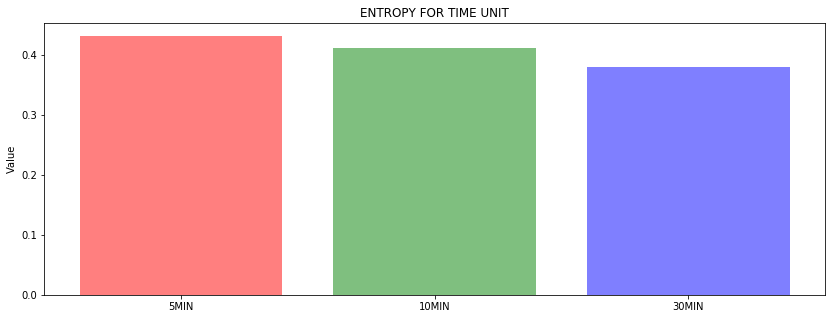

In [14]:
Entropy = pd.DataFrame(columns=['5MIN', '10MIN', '30MIN'])
Entropy.loc['value']={'5MIN':0.43190032,'10MIN': 0.41226993,'30MIN':0.3804699}
methods = ('5MIN', '10MIN','30MIN')

y_pos = np.arange(len(methods))

plt.figure(figsize=(14, 5)) 
MSEbar = plt.bar(y_pos, Entropy.loc['value'], align='center', alpha=0.5, color='rgbkymc') 
plt.xticks(y_pos, methods) 
plt.ylabel('Value') 
plt.title('ENTROPY FOR TIME UNIT') 
plt.show()